## Step 1: Install Kaggle and Setup

In [1]:
# Install required packages
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


## Step 2: Download Dataset

In [2]:
# Download the New Plant Diseases Dataset
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

# Unzip the dataset
!unzip -q new-plant-diseases-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.68G/2.70G [00:36<00:00, 74.4MB/s]
100% 2.70G/2.70G [00:37<00:00, 78.3MB/s]


## Step 3: Import Libraries

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Step 4: Data Preparation

In [30]:
# Set parameters
IMG_SIZE = 128        # Image size (128x128 pixels)
BATCH_SIZE = 32       # Number of images processed together
EPOCHS = 10           # Number of training rounds

# Set path for New Plant Diseases Dataset
train_path = 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_path = 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# Get class names from training folder
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

print(f"Number of plant disease classes: {num_classes}")
print(f"First 5 classes: {class_names[:5]}")

Number of plant disease classes: 38
First 5 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


## Step 5: Data Preprocessing

In [31]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation images
validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.

Training samples: 70295
Validation samples: 17572


## Step 6: Visualize Sample Images

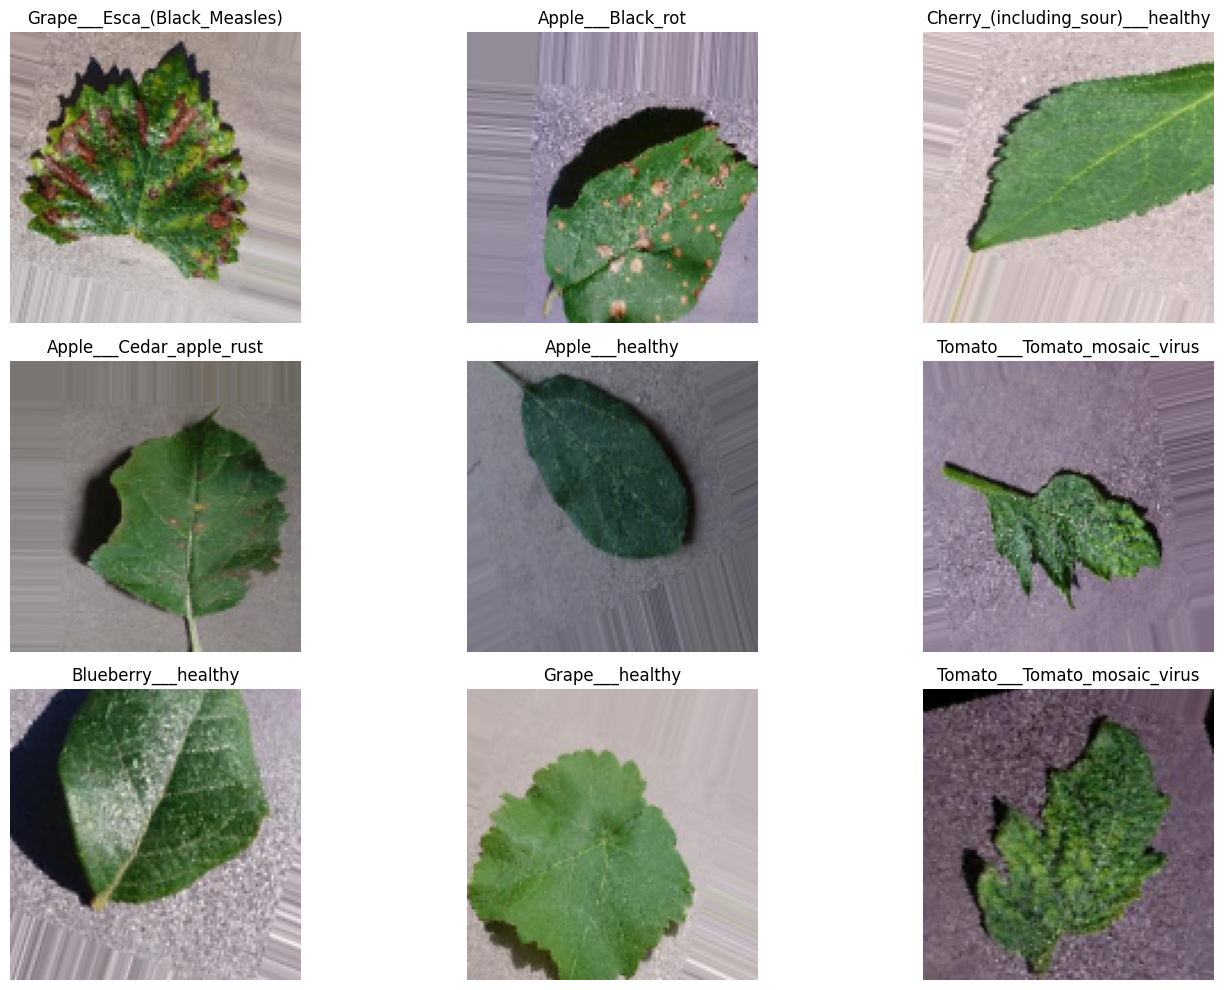

In [32]:
# Display some sample images
plt.figure(figsize=(15, 10))
for i in range(9):
    sample_images, sample_labels = next(train_generator)
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[0])
    plt.title(class_names[np.argmax(sample_labels[0])])
    plt.axis('off')
plt.tight_layout()
plt.show()

##  Step 7: Build CNN Model

In [33]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):

    model = models.Sequential([
        # Input Layer
        layers.Input(shape=input_shape),

        # First Block: Learn basic patterns (edges, colors)
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Block: Learn more complex patterns
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Block: Learn even more complex patterns
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth Block: Learn detailed features
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fifth Block: Learn very specific features
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten: Convert 2D data to 1D for classification
        layers.Flatten(),

        # Dense Layers: Make predictions
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Randomly drop 50% connections to prevent overfitting
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),  # Randomly drop 30% connections

        # Output Layer: Predict one of the disease classes
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,762,726 (10.54 MB)

 Trainable params: 2,760,742 (10.53 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Step 8: Compile Model

In [34]:
# Configure the model for training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Step 9: Train Model

In [35]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1
)

print("\nTraining Complete!")

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 366s 163ms/step - accuracy: 0.3286 - loss: 2.5098 - val_accuracy: 0.5430 - val_loss: 1.5791
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 355s 161ms/step - accuracy: 0.6855 - loss: 1.0490 - val_accuracy: 0.7536 - val_loss: 0.8020
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 346s 157ms/step - accuracy: 0.7873 - loss: 0.7163 - val_accuracy: 0.7688 - val_loss: 0.9185
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 350s 159ms/step - accuracy: 0.8322 - loss: 0.5784 - val_accuracy: 0.8040 - val_loss: 0.7115
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 346s 157ms/step - accuracy: 0.8576 - loss: 0.4936 - val_accuracy: 0.8016 - val_loss: 0.7909
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 383s 158ms/step - accuracy: 0.8809 - loss: 0.4205 - val_accuracy: 0.9025 - val_loss: 0.3183
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 351s 160ms/step - accuracy: 0.8916 - loss: 0.3849 - val_accuracy: 0.7634 - val_loss: 1.0738
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 352s 160ms/step - ac

## Step 10: Visualize Training Results

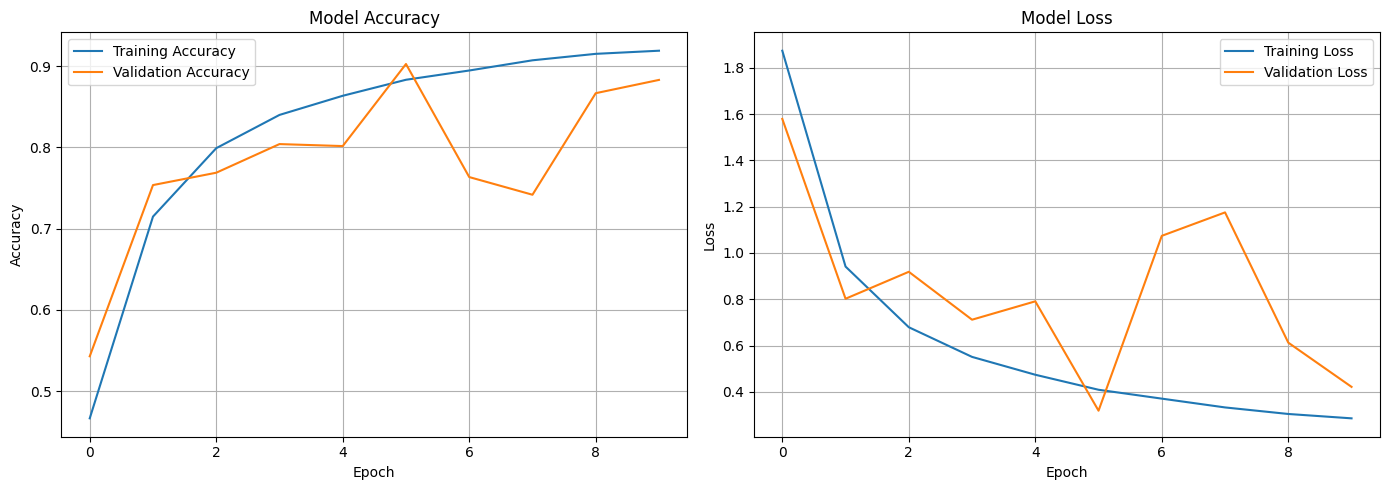

In [36]:
# Plot accuracy and loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Step 11: Evaluate Model

In [37]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\nFinal Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"\nFinal Validation Loss: {val_loss:.4f}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.8873 - loss: 0.3967

Final Validation Accuracy: 88.29%

Final Validation Loss: 0.4213


## Step 12: Save Model and Class Names

In [40]:
# Save the trained model
model.save('plant_disease_model.keras')
print("\nModel saved as 'plant_disease_model.keras'")

# Save class names
import json
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved as 'class_names.json'")

# Download both files to Local Machine
from google.colab import files
files.download('plant_disease_model.keras')
files.download('class_names.json')


Model saved as 'plant_disease_model.keras'
Class names saved as 'class_names.json'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>